In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
# link: https://figshare.com/articles/dataset/Data_from_Method_of_place_cell_classification_determines_the_population_of_cells_identified/13560548
import os 

pths = [r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190827\NikNak_20190827",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827\Popchips_20190827",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190830\Cheeto_20190830",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190829\Cheeto_20190829",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190826\NikNak_20190826",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827_1\Popchips_20190827_1",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Voltorb_20190828\Voltorb_20190828",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Voltorb_20190829\Voltorb_20190829",]        

stacked_F = []
stacked_spks = []

for pth in pths:
    loco_path = os.path.join(pth, 'locomotion.mat')
    print(loco_path)
    loco = loadmat(loco_path)
    loco = loco['loco'] * 200

    fall_path = os.path.join(pth, 'Fall.mat')
    fall = loadmat(fall_path)
    fall.keys()

    F = fall['F']
    Fneu = fall['Fneu']
    spks = fall['spks']
    iscell = fall['iscell']
    valid_ids = np.where(iscell[:,0]==1)[0]
    valid_probs = np.where(iscell[:,1]>0.5)[0]
    valid_ids = np.array(valid_ids, dtype=int)
    valid_probs = np.array(valid_probs, dtype=int)
    valid_ids = [x for x in valid_ids if x in valid_probs]

    F = F[valid_ids,:]
    Fneu = Fneu[valid_ids,:]
    spks = spks[valid_ids,:]
    F = F - 0.7*Fneu
    # for i in range(len(spks)):
        # cpy = np.zeros(spks[i].shape)
        # cpy[spks[i]>2.5*np.std(spks[i, :])] = 1 
        # spks[i] = cpy

    F = preprocess_data(F)


    stacked_F.append(F[:, :19999])
    stacked_spks.append(spks[:, :19999])

F = np.vstack(stacked_F)
spks = np.vstack(stacked_spks)


C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190827\NikNak_20190827\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827\Popchips_20190827\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190830\Cheeto_20190830\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190829\Cheeto_20190829\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190826\NikNak_20190826\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827_1\Popchips_20190827_1\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.col

In [100]:
import numpy as np

def preprocess_data(data, window_size=int(15*7.5), threshold_multiplier=2, end_threshold_multiplier=0.5):
    """
    Preprocesses the input data using the modified method.

    Parameters:
        data (numpy.ndarray): Input time series data.
        window_size (int): Size of the window in seconds for baseline calculation.
        threshold_multiplier (float): Multiplier for standard deviation to identify significant transients.
        end_threshold_multiplier (float): Multiplier for standard deviation to identify the end of transients.

    Returns:
        numpy.ndarray: Preprocessed data.
    """
    num_samples, num_cells = data.shape
    preprocessed_data = np.zeros((num_samples, num_cells))
    
    windows_processed_data = []
    
    for i in range(0, num_samples, window_size):
        window_data = data[i:i + window_size, :]
        
        # Calculate baseline as the 8th percentile within the window
        baseline = np.percentile(window_data, 8, axis=0)
        
        # Handle case where baseline is 0 to prevent division by zero
        # baseline[baseline == 0] = 1
        
        # Normalize cell trace by subtracting the baseline
        normalized_data = window_data - baseline.reshape(1, -1)
        
        # Store processed data for this window
        windows_processed_data.append(normalized_data)
    
    normalized_data = np.vstack(windows_processed_data)
    # Identify significant transients for the entire trace of each cell
    start_condition = normalized_data > threshold_multiplier * np.std(normalized_data, axis=0)
    end_condition = normalized_data < -end_threshold_multiplier * np.std(normalized_data, axis=0)
    # significant_events = start_condition & end_condition

    # # Set fluorescence outside of significant events to 0
    # preprocessed_data = np.where(significant_events, normalized_data, 0)

    # Combine start and end conditions to identify significant events
    significant_events = np.zeros_like(normalized_data)
    event_started = False
    
    for j in range(num_cells):
        for t in range(normalized_data.shape[0]):
            if start_condition[t, j]:
                event_started = True
            if event_started:
                significant_events[t, j] = 1
            if end_condition[t, j] and event_started:
                event_started = False
    
    # Set fluorescence outside of significant events to 0
    preprocessed_data = np.where(significant_events, normalized_data, 0)
    
    
    return preprocessed_data


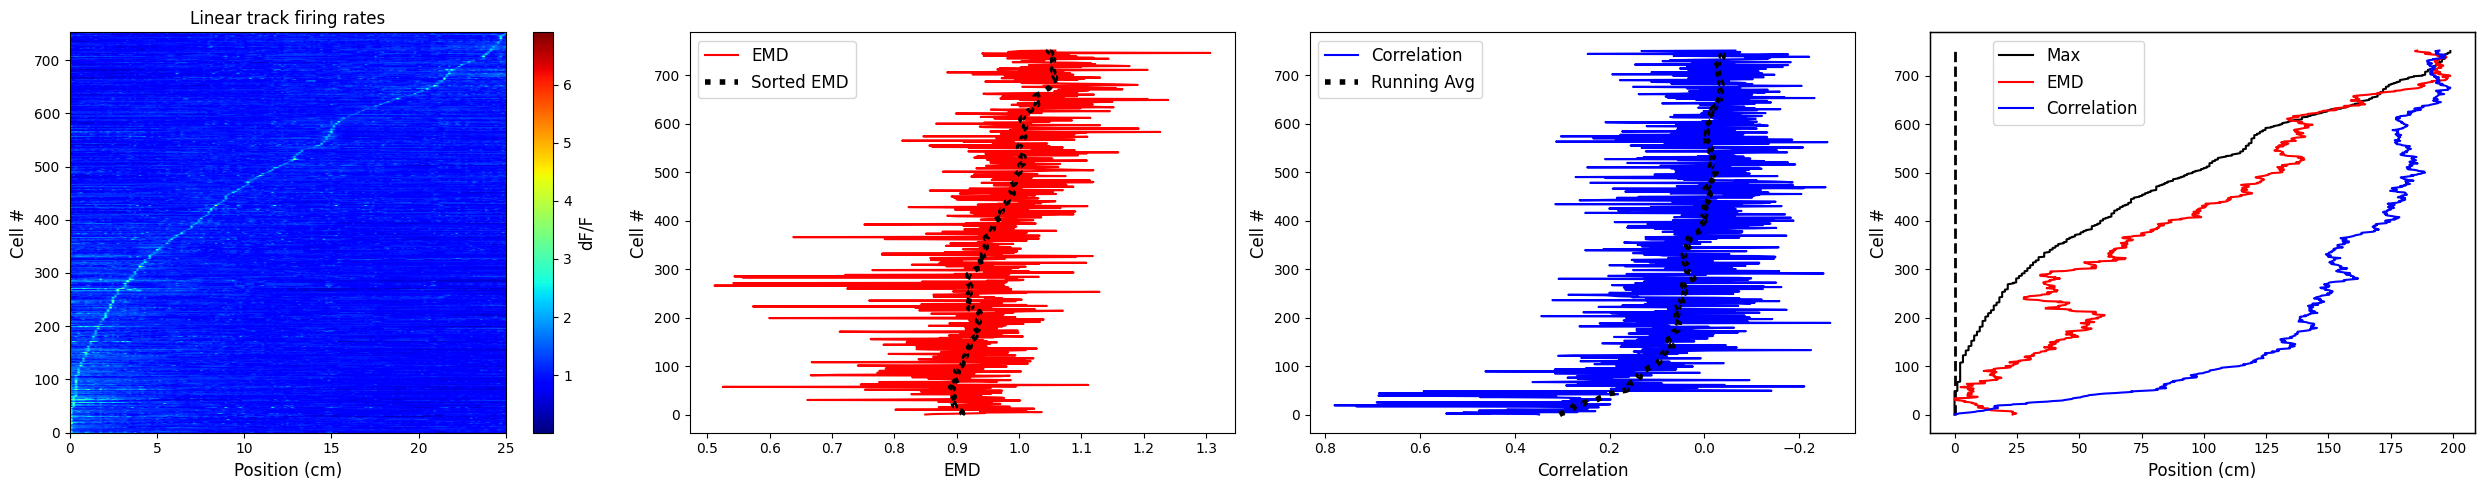

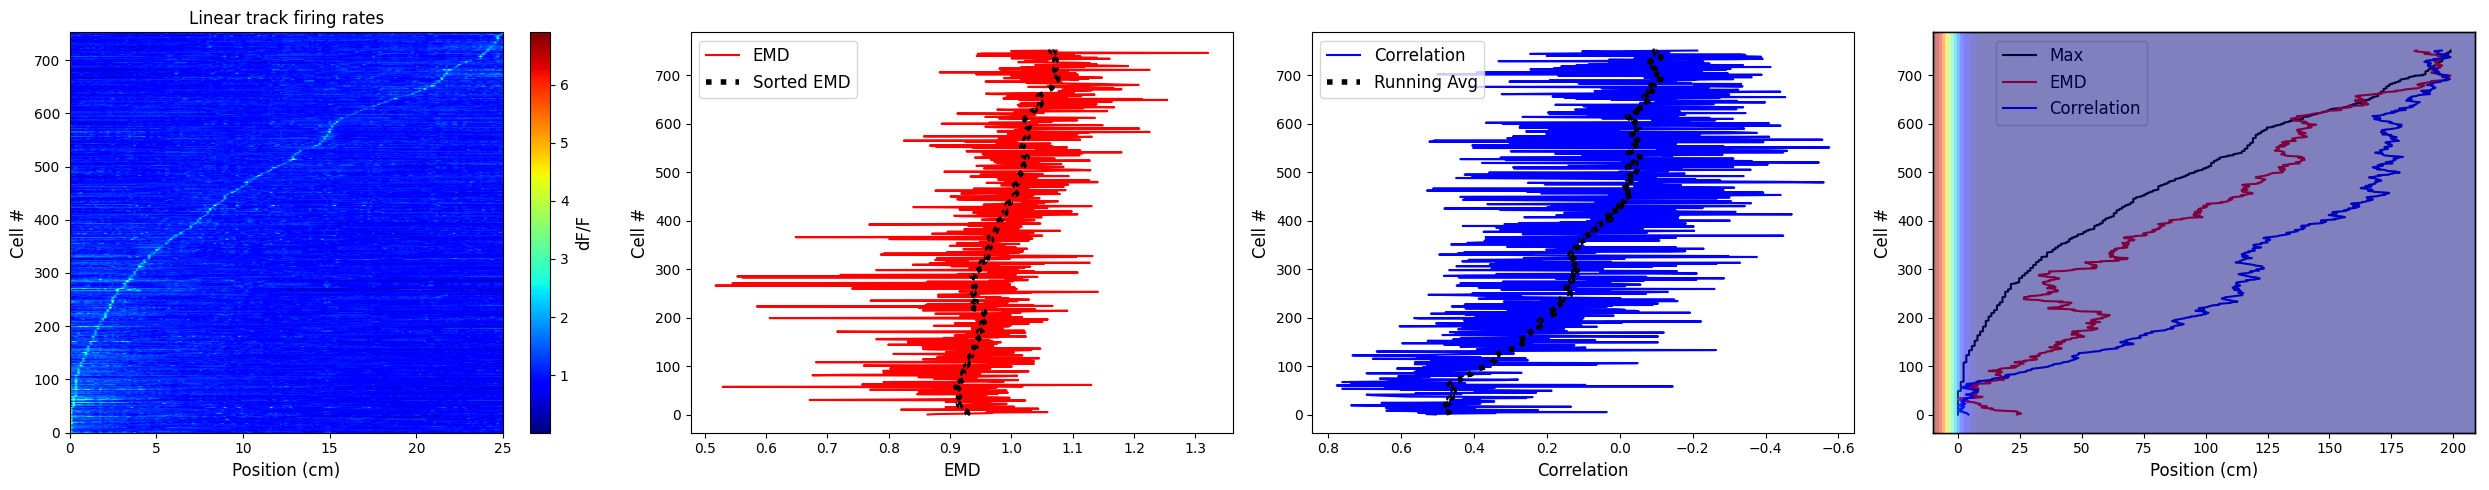

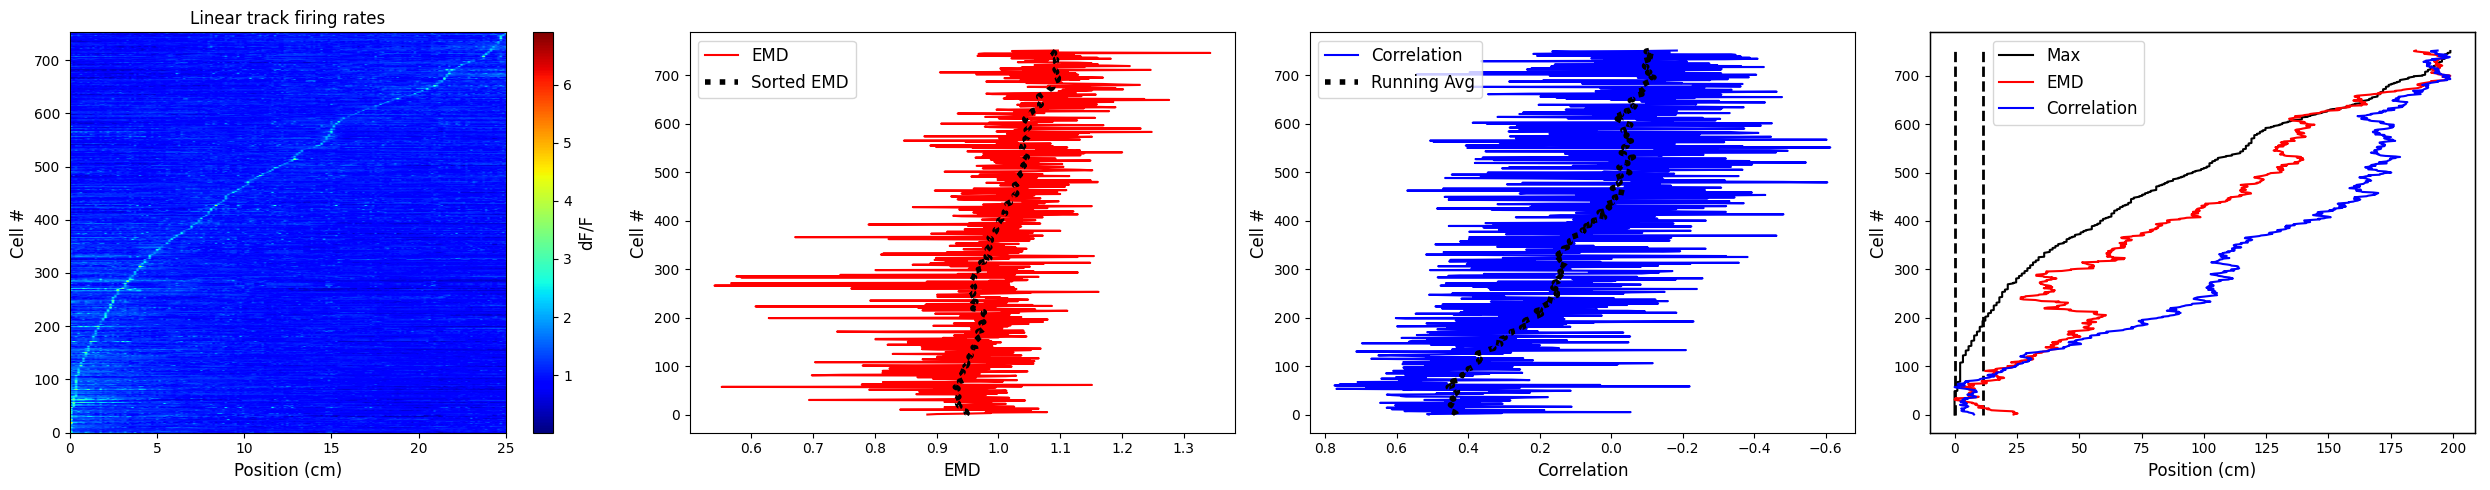

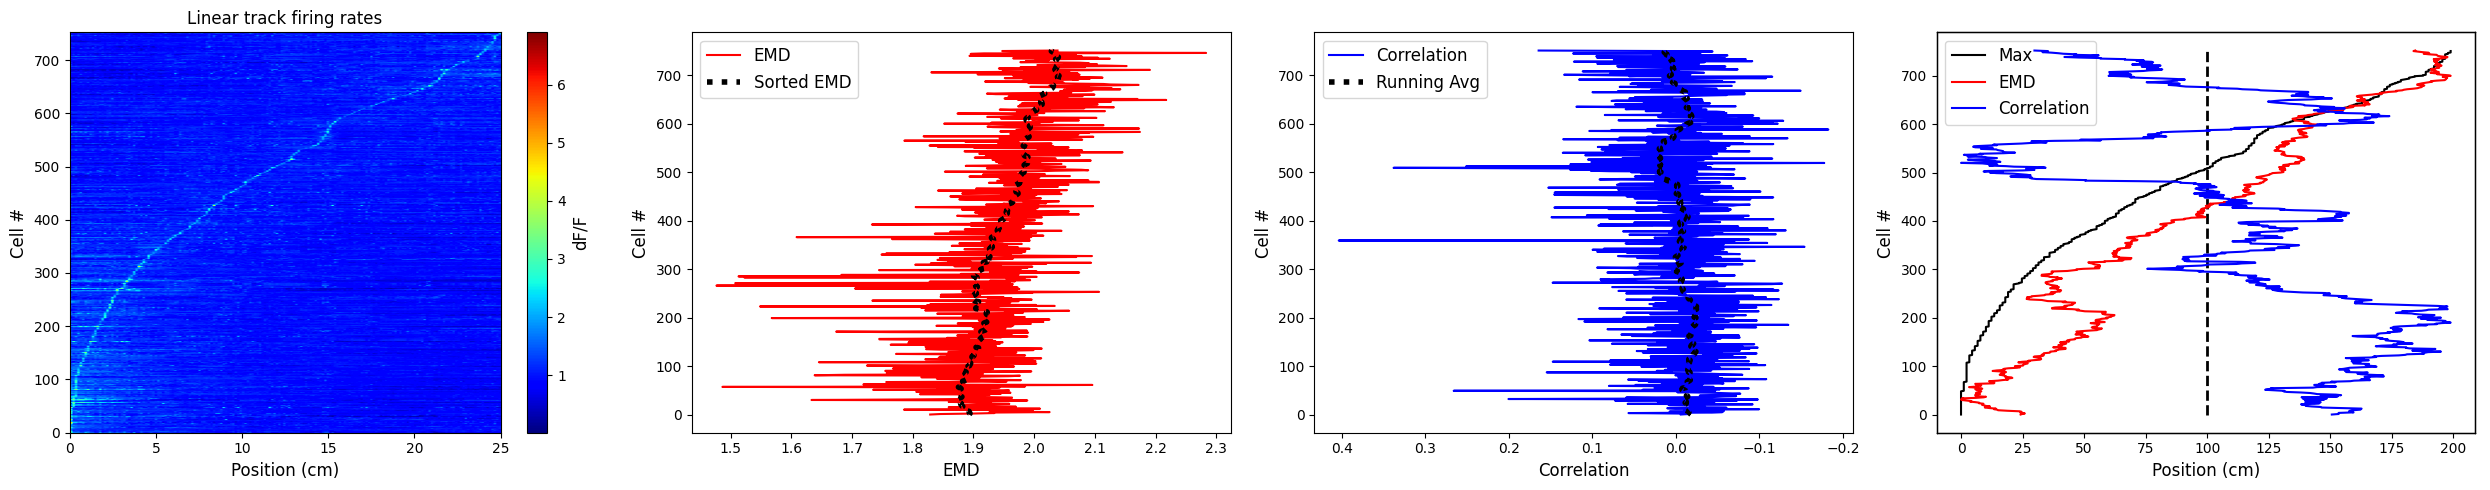

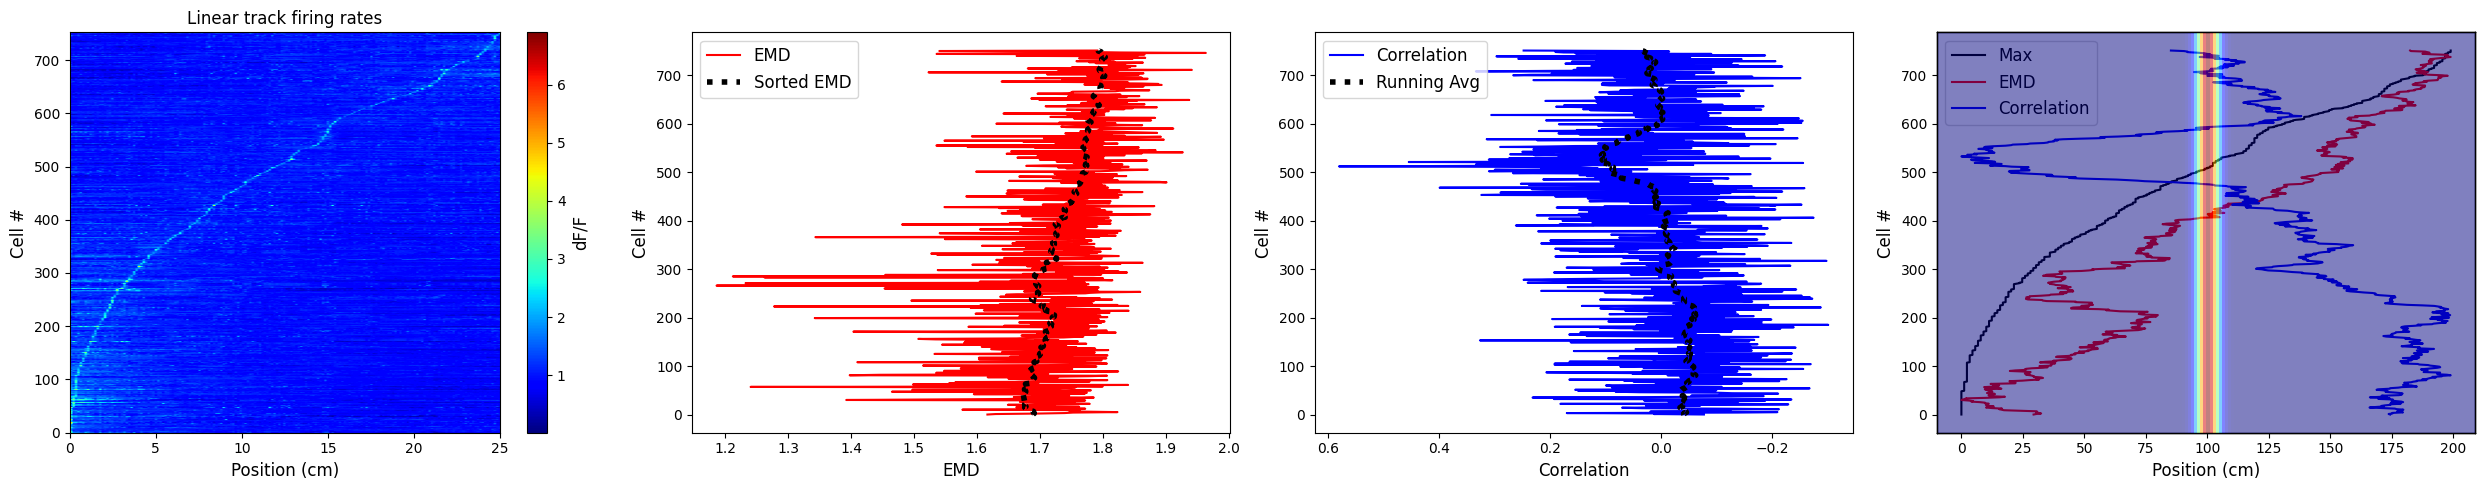

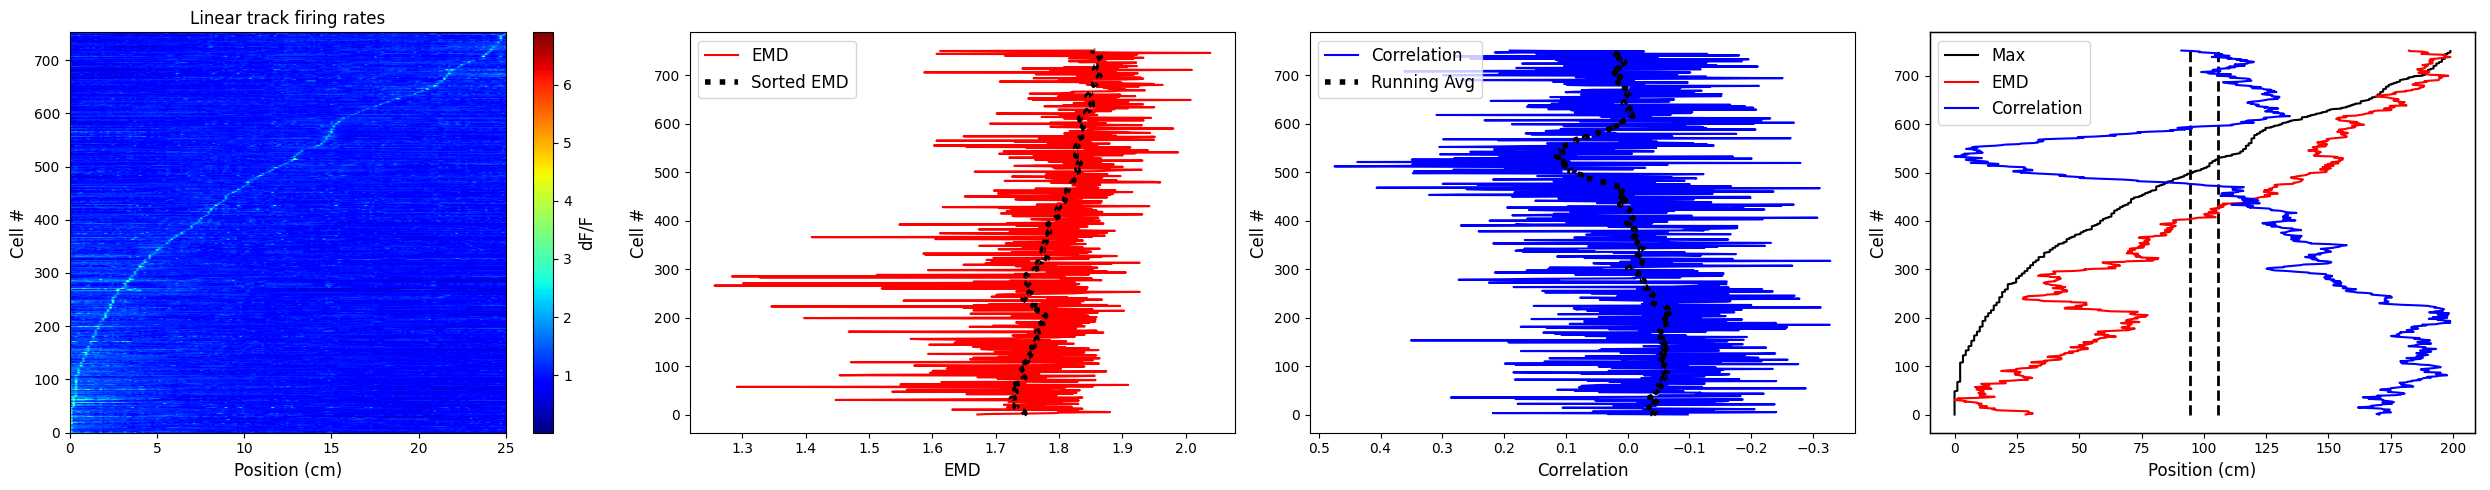

In [256]:
# # For each ROI, fluorescence time courses were normalised to baseline fluorescence by dividing the whole trace by the average intensity in that ROI during the first 100 frames of the recording.
# F = F / np.mean(F[:,:100], axis=1)[:,None]
# # drop rows average F is too large
# keep_F = []
# for f in F:
#     if np.max(f) > 1000 or np.min(f) < -400:
#         pass
#     else:
#         keep_F.append(f)

# keep_F = np.array(keep_F)
# # divide by the baseline, which was defined as the 8th percentile of values in each ~15 second interval
inf_contents = []
keep_spks = []
keep_spks_order = []
max_line = []
keep_spks_unchanged = []
for spk in spks:
    # idx_event = np.where(spk >= 3*np.std(spk))[0]
    # new_spk = np.zeros_like(spk)
    # new_spk[idx_event] = 1
    # frames_to_sum = 150
    # total_sums = len(new_spk) // frames_to_sum
    # new_spk = new_spk[:total_sums * frames_to_sum].reshape(-1, frames_to_sum)
    # new_spk = np.mean(new_spk, axis=1)
    # keep_spks.append(new_spk)
    # keep_spks_order.append(np.argmax(spk))

    # if np.max(spk) > 10000:
    #     pass
    if True:
        # print('new')
        # print(np.mean(spk[:100]), np.max(spk))
        # spk = spk / np.mean(spk[:100])
        # spk = spk.squeeze()
        # print(np.mean(spk), np.max(spk))
        # if np.max(spk) < 1000 and np.min(spk) > 0:
        if True:
            spk_copy = np.copy(spk)
            frames_to_sum = int(7.5*15)
            total_sums = len(spk) // frames_to_sum
            spk = spk[:total_sums * frames_to_sum].reshape(-1, frames_to_sum)
            spk = np.mean(spk, axis=1)/15
            if np.min(spk) > 0 and np.mean(spk) > 0.1:
                # and np.max(spk) < 1000 and np.mean(spk) > 0.1:
                spk = spk / np.mean(spk)

                # mean_rate = np.mean(spk)
                # log_argument = spk / mean_rate
                # log_argument[log_argument < 1] = 1
                # inf_rate = np.ma.sum(spk * np.ma.log2(log_argument))
                # inf_content = inf_rate / mean_rate

                # inf_contents.append(inf_content)
                keep_spks_unchanged.append(spk_copy)
                keep_spks.append(spk)
                keep_spks_order.append(np.argmax(spk))
                index_at_max = np.argmax(spk)
                position_at_max = index_at_max * 200 / len(spk)
                max_line.append(position_at_max)

keep_spks = np.array(keep_spks)[np.argsort(keep_spks_order)[::-1]]
# plt.imshow(keep_spks, aspect='auto', cmap='jet')
# plt.show()
# stop()


max_line = np.array(max_line)[np.argsort(keep_spks_order)[::-1]]
reference = np.zeros_like(keep_spks[0])
# reference = np.mean(keep_spks[0])
midpoint = len(reference)//2
# reference_midpoint = np.copy(reference)
# reference_midpoint[midpoint-1:midpoint+1] = 1

ref_start = np.zeros_like(keep_spks[0])
ref_start[0] = 1

# ref_start_narrow = np.zeros_like(keep_spks[0])
# ref_start_narrow[0:5] = 1
from scipy.ndimage import gaussian_filter1d
ref_start_narrow =  gaussian_filter1d(ref_start, sigma=5)
ref_start_narrow = ref_start_narrow / np.mean(ref_start_narrow)
# plt.plot(ref_start_narrow)
# plt.show()
# stop()

ref_start_wide = np.zeros_like(keep_spks[0])
ref_start_wide[0:10] = 1

ref_end = np.zeros_like(keep_spks[0])
ref_end[midpoint] = 1

# ref_end_narrow = np.zeros_like(keep_spks[0])
# ref_end_narrow[midpoint-2:midpoint+3] = 1
ref_end_narrow = gaussian_filter1d(ref_end, sigma=5/2)
ref_end_narrow = ref_end_narrow / np.mean(ref_end_narrow)

ref_end_wide = np.zeros_like(keep_spks[0])
ref_end_wide[midpoint-5:midpoint+5] = 1

positions = np.arange(0, 200, 200/len(ref_start))
# average of first 10 cells
# avg = np.mean(keep_spks[:10], axis=0)
count = 0
for reference in [ref_start, ref_start_narrow, ref_start_wide, ref_end, ref_end_narrow, ref_end_wide]:
# ref1 = keep_spks[0]
# ref2 = keep_spks[1]
# ref3 = keep_spks[2]

# ref4 = np.mean(keep_spks[:10], axis=0)
# ref5 = np.mean(keep_spks[:100], axis=0)
# ref6 = np.mean(keep_spks[:], axis=0)

# for reference in [ref1, ref2, ref3, ref4, ref5, ref6]:
    reference = reference / np.mean(reference) 
    emds = []
    corrs = []
    from scipy.stats import pearsonr, spearmanr
    from scipy.stats import wasserstein_distance
    count2 = 0
    for spk in keep_spks:

        # first_half = spk[:len(spk)//2]
        # second_half = spk[len(spk)//2:]

        # corrs.append(np.corrcoef(reference, spk)[0,1])

        r, p = pearsonr(reference, spk)
        # ref_unchanged = np.zeros(len(keep_spks_unchanged[count]))
        # ref_unchanged[0] = 1
        # r, p = pearsonr(ref_unchanged, keep_spks_unchanged[count])
        
        # r, p = spearmanr(first_half, second_half)
        corrs.append(r)
        
        emd = wasserstein_distance(reference, spk, positions, positions)
        # emd = wasserstein_distance(first_half, second_half, positions[:len(spk)//2], positions[len(spk)//2:])
        emds.append(emd)
        count2 += 1

    fig = plt.figure(figsize=(25,5))

    ax = fig.add_subplot(1, 4, 1)
                    
    img = ax.imshow(keep_spks, aspect='auto', cmap='jet', extent=[0, 25, 0, len(keep_spks)])
    ax.set_title('Linear track firing rates', fontsize=12)

    ax1 = ax
    
    ax.set_ylabel('Cell #',fontsize=12)
    ax.set_xlabel('Position (cm)',fontsize=12)
    cbar = plt.colorbar(img, ax=ax, label='dF/F')
    cbar.set_label('dF/F', fontsize=12)

    ax = fig.add_subplot(1, 4, 2)
    
    l1 = ax.plot(np.flip(emds), np.arange(0,len(emds)),color='red')
    window_size = int(0.1*len(emds))
    smooth_trace_emd = np.convolve(np.flip(emds), np.ones(window_size)/window_size, mode='valid')
    l2 = ax.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)),'k:',lw=4)
    # l2 = ax.plot(np.sort(np.flip(emds)), np.arange(0,len(emds)),'k:',lw=4)
    ax.set_ylabel('Cell #',fontsize=12)
    ax.set_xlabel('EMD',fontsize=12)
    # axt2 = ax.twinx().twiny()
    # axt2.set_ylabel('Cell #',fontsize=12)
    # axt2.set_xlabel('Position (cm)',fontsize=12)

    # ax2 = axt2

    # if count >= 3:
    # l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    #     axt2.set_xlim(axt2.get_xlim()[::-1])
    # else:
    #     l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
        
    legend_properties = {'size': 12}

    # if count >= 3:
    ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc='upper left', prop=legend_properties)
    # else:
    #     # ax.set_xlim(0)
    #     ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc ='upper left', bbox_to_anchor=(0.1, 1), prop=legend_properties)

    ax = fig.add_subplot(1, 4, 3)
    l1 = ax.plot(np.flip(corrs), np.arange(0,len(corrs)),color='blue')
    window_size = int(0.1*len(corrs))
    smooth_trace_corr = np.convolve(corrs, np.ones(window_size)/window_size, mode='valid')
    smooth_trace_corr = np.flip(smooth_trace_corr)
    l2 = ax.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)),'k:',lw=4)

    # flip x axis
    ax.invert_xaxis()
    ax.set_ylabel('Cell #',fontsize=12)
    ax.set_xlabel('Correlation',fontsize=12)
    # axt2 = ax.twinx().twiny()
    # axt2.set_ylabel('Cell #',fontsize=12)
    # axt2.set_xlabel('Position (cm)',fontsize=12)
    # if count >= 3:
    # l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    #     axt2.set_xlim(axt2.get_xlim()[::-1])
    # else:
    #     l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
        
    legend_properties = {'size': 12}

    # if count >= 3:
    ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc='upper left', prop=legend_properties)
    # else:
    #     ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc ='upper left', bbox_to_anchor=(0.1, 1), prop=legend_properties) 
    
    # ax3 = axt2

    ax = fig.add_subplot(1, 4, 4)
    lbl_max = ax.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    ax_emd = ax.twinx().twiny()
    lbl_emd = ax_emd.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)), color='red')
    # hide x and y ticks
    ax_emd.set_xticks([])
    ax_emd.set_yticks([])
    ax_corr = ax.twinx().twiny()
    lbl_corr = ax_corr.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)), color='blue')
    # hide x and y ticks
    ax_corr.set_xticks([])
    ax_corr.set_yticks([])
    ax_corr.invert_xaxis()

    if count == 1:
        ax_again = ax.twinx().twiny()
        toplot = ref_start_narrow.reshape(-1,1)
        # toplot[toplot< 0.001] = np.nan
        ax_again.imshow(toplot.T, cmap='jet', aspect='auto', alpha=0.5)
        ax_again.set_xticks([])
        ax_again.set_yticks([])
    elif count == 4:
        ax_again = ax.twinx().twiny()
        toplot = ref_end_narrow.reshape(-1,1)
        # toplot[toplot< 0.001] = np.nan
        ax_again.imshow(toplot.T, cmap='jet', aspect='auto', alpha=0.5)
        ax_again.set_xticks([])
        ax_again.set_yticks([])
        


    ax.set_ylabel('Cell #',fontsize=12)
    ax.set_xlabel('Position (cm)',fontsize=12)

    for ax in [ax,]:
        if count == 0:
            ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        # elif count == 1:
        #     ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        #     ax.vlines(positions[5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        elif count == 2:
            ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
            ax.vlines(positions[10], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        elif count == 3:
            ax.vlines(positions[midpoint], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        # elif count == 4:
        #     ax.vlines(positions[midpoint-2], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        #     ax.vlines(positions[midpoint+3], 0, len(keep_spks), color='k', linestyle='--', lw=2)

        elif count == 5:
            ax.vlines(positions[midpoint-5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
            ax.vlines(positions[midpoint+5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
    # legend
    legend_properties = {'size': 12}
    if count >= 3:
        ax.legend([lbl_max[0], lbl_emd[0], lbl_corr[0]], ['Max', 'EMD', 'Correlation'], loc='upper left', prop=legend_properties)
    else:
        ax.legend([lbl_max[0], lbl_emd[0], lbl_corr[0]], ['Max', 'EMD', 'Correlation'], loc ='upper left', bbox_to_anchor=(0.1, 1), prop=legend_properties)

            
    

    fig.tight_layout()
    plt.show()

    count += 1

In [258]:
print(len(keep_spks), len(F))

752 908


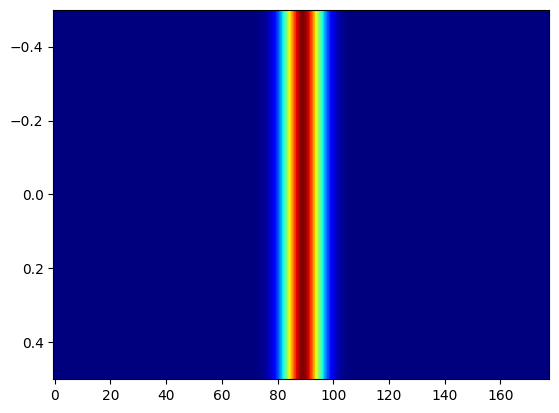

In [229]:

plt.imshow(ref_end_narrow.reshape(1,-1), aspect='auto', cmap='jet')

In [606]:
inf_contents

[40.710144,
 44.285137,
 54.539425,
 43.317947,
 51.796432,
 65.02569,
 38.522346,
 68.67786,
 49.887695,
 53.992943,
 56.169052,
 47.916946,
 42.512264,
 41.75991,
 42.461815,
 47.612484,
 46.218464,
 45.3259,
 35.705723,
 36.37984,
 44.384087,
 38.363956,
 35.15486,
 57.361847,
 54.488075,
 36.008312,
 63.247448,
 51.1447,
 32.38618,
 31.322716,
 29.36864,
 41.640182,
 44.890022,
 34.387398,
 29.263613,
 40.41849,
 35.93578,
 20.9781,
 23.284176,
 26.970007,
 28.524345,
 36.8647,
 29.403114,
 45.369682,
 25.65013,
 44.591015,
 22.666275,
 31.63099,
 25.100636,
 23.200441,
 30.858797,
 27.277477,
 50.49003,
 27.119751,
 45.40842,
 26.941418,
 21.704992,
 29.456985,
 29.135431,
 27.64353,
 34.346138,
 21.273151,
 49.710255,
 27.789633,
 15.1640215,
 27.762894,
 22.346907,
 28.69284,
 36.44082,
 40.307995,
 35.18412,
 18.857113,
 26.106018,
 27.04243,
 24.299961,
 15.973735,
 16.90012,
 25.122763,
 36.28947,
 22.68157,
 22.5469,
 30.195036,
 47.567913,
 43.68226,
 42.387337,
 37.671234,

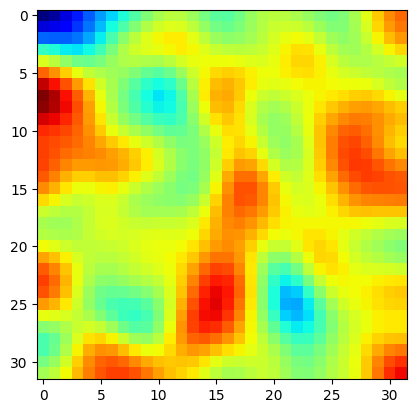

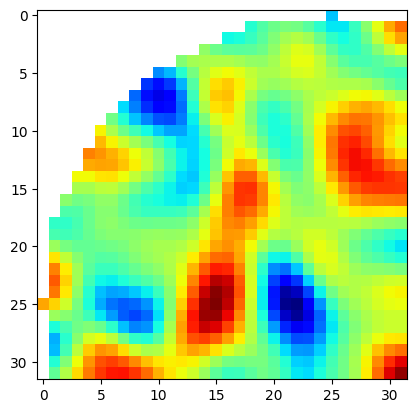

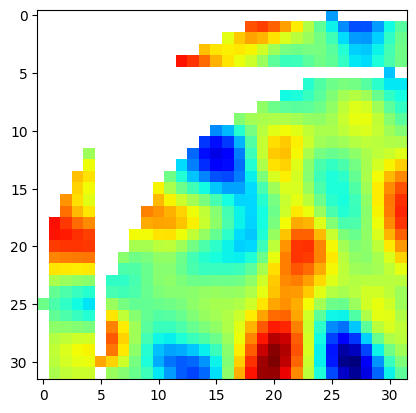

In [519]:
import numpy as np
ratemap = np.random.rand(32, 32)
# smooth the ratemap
from scipy.ndimage import gaussian_filter
ratemap = gaussian_filter(ratemap, sigma=2)
ratemap = ratemap / np.max(ratemap)

plt.imshow(ratemap, cmap='jet')
plt.show()
# Assuming your ratemap is called ratemap and has shape (32, 32)
mask_radius = 25  # Adjust the radius of the circular mask as needed
mask_center = (mask_radius, mask_radius)
mask = np.ones((32, 32))
y, x = np.ogrid[-mask_center[0]:mask.shape[0]-mask_center[0], -mask_center[1]:mask.shape[1]-mask_center[1]]
mask_circle = x*x + y*y <= mask_radius*mask_radius
mask[mask_circle] = 0

ratemap[mask.astype(bool)] = np.nan
plt.imshow(ratemap, cmap='jet')
plt.show()

shift_center = (5, 5)  # Adjust the shift values as needed
shifted_ratemap = np.roll(ratemap, shift=shift_center, axis=(0, 1))
shifted_ratemap[mask.astype(bool)] = np.nan

plt.imshow(shifted_ratemap, cmap='jet')
plt.show()


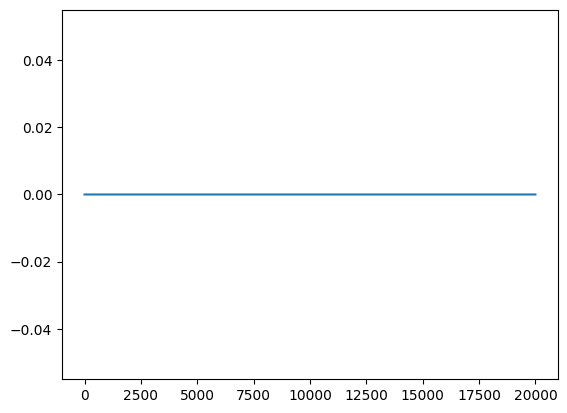

In [501]:
plt.plot(spk)

In [488]:
np.min(F)

-433.3315

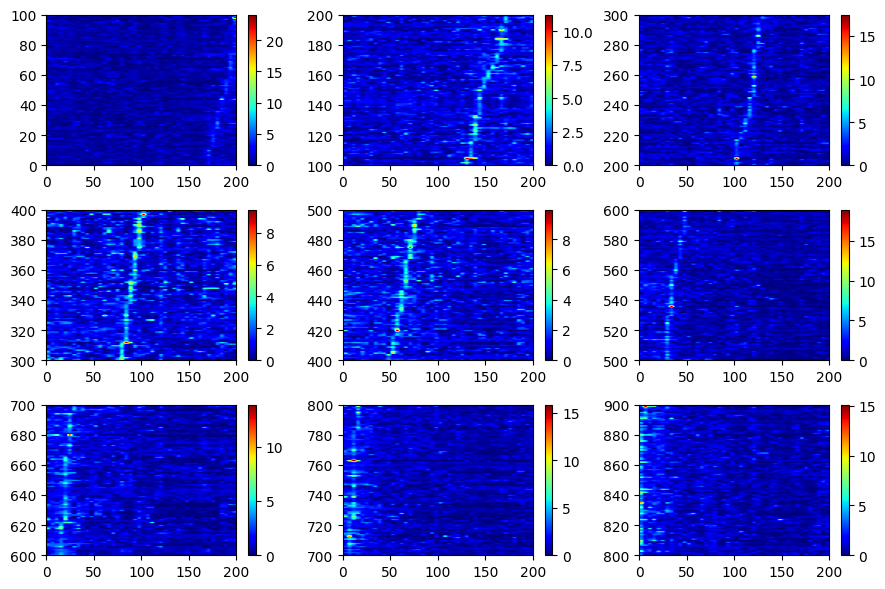

In [469]:
fig = plt.figure(figsize=(9,6))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    img = ax.imshow(keep_spks[100*i:100*(i+1)], aspect='auto', cmap='jet', extent=[0,200,100*i,100*(i+1)])
    plt.colorbar(img, ax=ax)

fig.tight_layout()
plt.show()


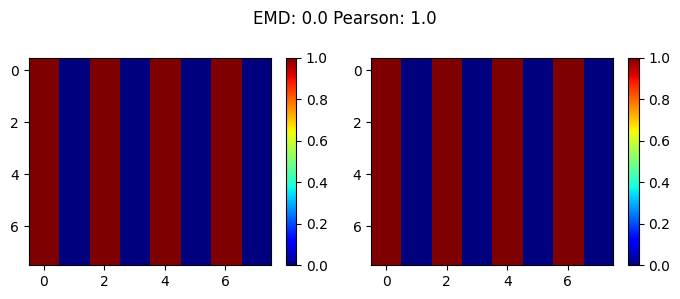

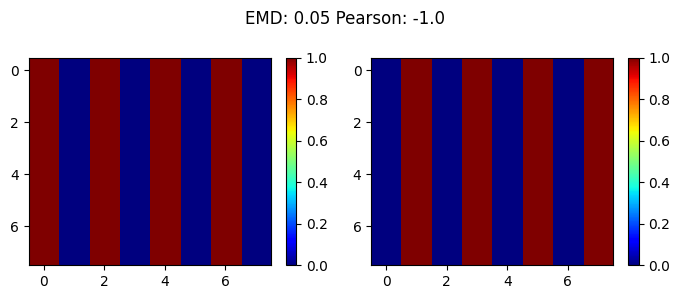

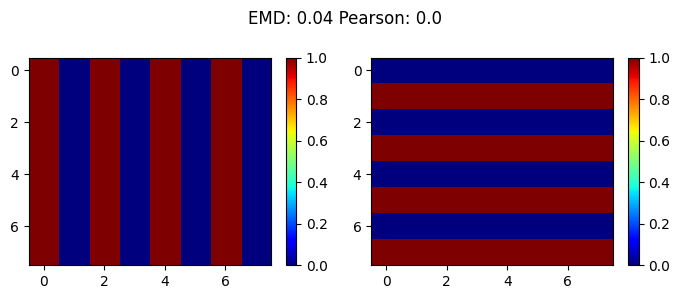

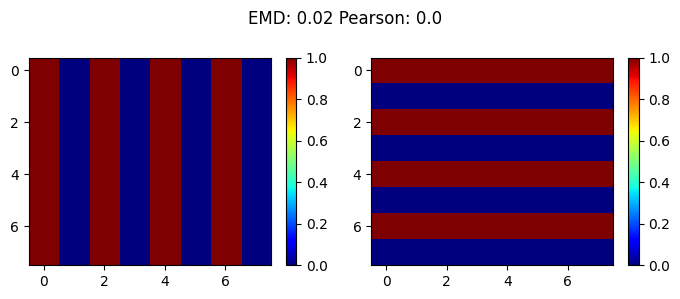

In [205]:
# make grid of alternating columns of 0s and 1s
sze = 8

g1 = np.zeros((sze, sze))
for i in range(sze):
    if i % 2 == 0:
        g1[:,i] = 1

g2 = np.zeros((sze, sze))
for i in range(sze):
    if i % 2 != 0:
        g2[:,i] = 1

# 2d positions
positions = []
for i in range(sze):
    for j in range(sze):
        positions.append([i,j])
# print(positions.shape, g1.shape, g2.shape)
emd = wasserstein_distance(g1.flatten(), g1.flatten(), positions, positions)
pearson = np.corrcoef(g1.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 2)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

emd = wasserstein_distance(g1.flatten(), g2.flatten(), positions, positions)
pearson = np.corrcoef(g1.flatten(), g2.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 2)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g2, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

# rotate g1
g1_rot = np.rot90(g1)
emd = wasserstein_distance(g1_rot.flatten(), g1.flatten(), positions, positions)
pearson = np.corrcoef(g1_rot.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 17)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g1_rot, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

# rotate g2
g2_rot = np.rot90(g2)
emd = wasserstein_distance(g2_rot.flatten(), g1.flatten(), positions, positions)
pearson = np.corrcoef(g2_rot.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 17)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g2_rot, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
    